In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import uproot
import awkward as ak
# !pip install "uproot[http]"
# !pip install awkward-pandas

In [ ]:
cernbox = '/Users/emiliebertholet/cernbox/coldbox_data'
# filepath = "tests/run_025034_cosmics.root"

# filepath = f'{cernbox}/anaCRP_files/run_025034_PNS.root'
# filepath = f'{cernbox}/anaCRP_files/run_025034_pns0.root' # 332

filepath = f'{cernbox}/anaCRP_files/run_025036_pns0.root' # 332

file = uproot.open(filepath)
print(type(file))
file.keys()


<class 'uproot.reading.ReadOnlyDirectory'>


['PNSCRPanalyzerflashes1;1',
 'PNSCRPanalyzerflashes1/Event;13',
 'PNSCRPanalyzerflashes1/Event;12']

In [3]:

# evts = uproot.open(f"{filepath}:PNSCRPanalyzercosmics/Event") #library='pd'
evts = uproot.open(f"{filepath}:PNSCRPanalyzerflashes1/Event") #library='pd'
# evts.show()


In [4]:
cols = evts.keys()
akw = evts.arrays(filter_name=evts.keys(), library="ak")
print(len(akw['event']))
akw

332


<Array [{event: 1, evttime: ..., ...}, ...] type='332 * {event: int32, evtt...'>

## Waveforms

In [5]:
Nevents    = len(akw['waveformsADC'])
TrigWindow = len(akw['waveformsADC'][0][0])
Nchannels  = len(akw['waveformsADC'][0])
print('events', Nevents)
print('trigger window', TrigWindow)
print('waveforms per event', len(akw['waveformsADC'][0]))

events 332
trigger window 65600
waveforms per event 12


Text(0, 0.5, 'waveformsADC')

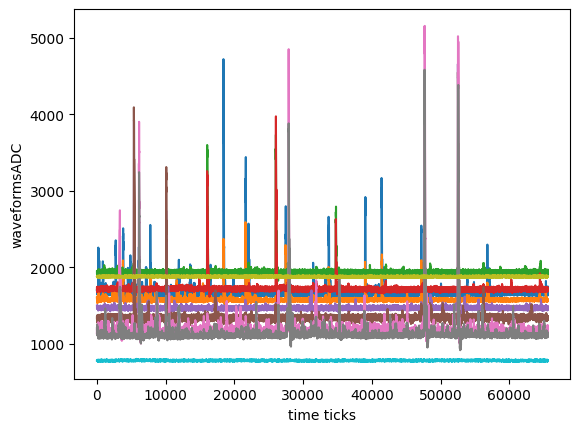

In [6]:
evtID = 0
x = np.arange(0,  TrigWindow, 1)
y = 'waveformsADC'

# issues: 7, 10 (membranes?)

# for chID in range(0, 12):
for chID in [0, 1, 2, 3, 4, 5, 6, 8, 9, 11]:
    plt.plot(x, akw[y][evtID][chID].to_numpy());

plt.xlabel('time ticks')
plt.ylabel(y)
# plt.xlim(0, 10000)
# plt.ylim(0, 1000)

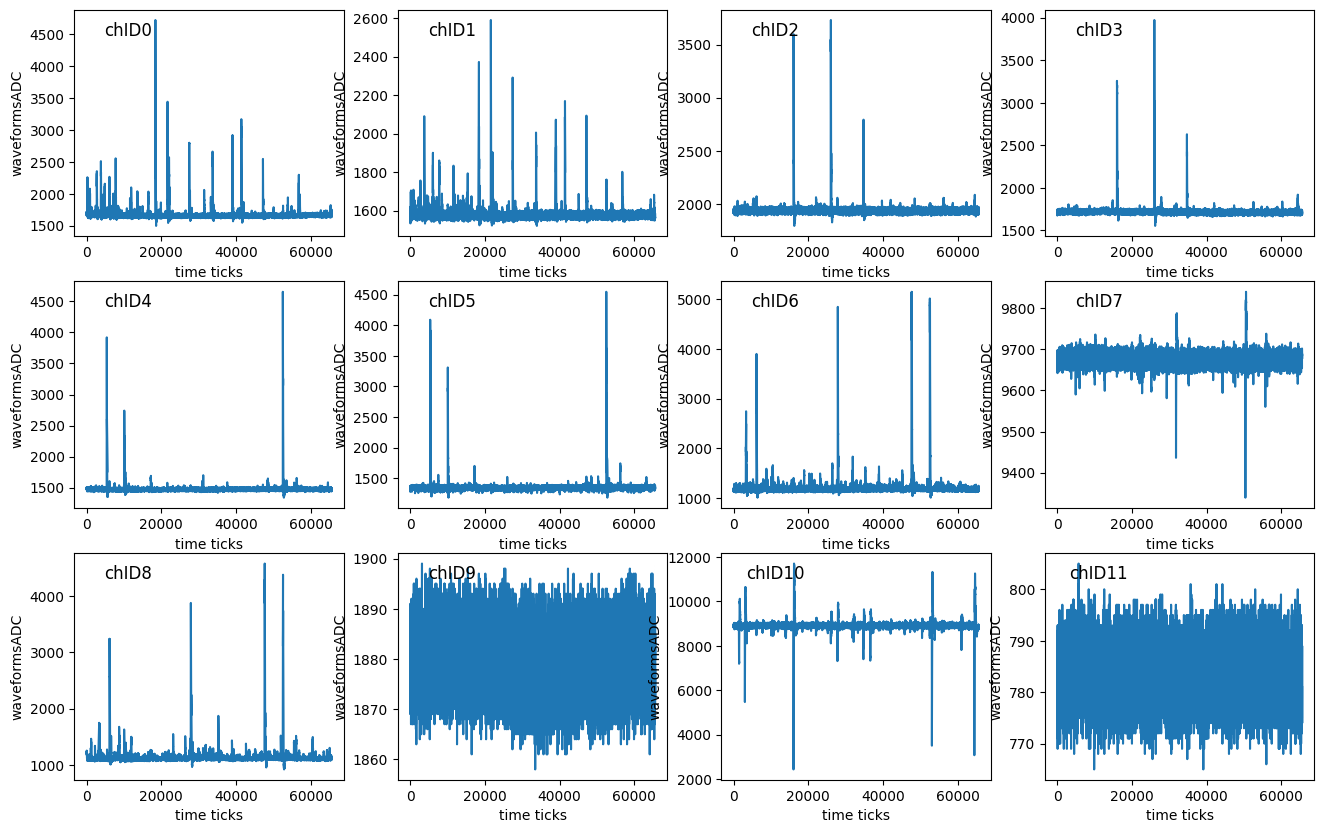

In [7]:
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

evtID = 0
x = np.arange(0,TrigWindow, 1)
y = 'waveformsADC'

a = 0
for chID in range(0, Nchannels):
    ax = axs.flatten()[a]
    ax.plot(x, akw[y][evtID][chID].to_numpy());
    a+=1
    ax.set_xlabel('time ticks')
    ax.set_ylabel(y)
    ax.set_title(f'chID{chID}', x=0.2,  y = 0.85)



### histogram of peak positions

In [8]:
from scipy.signal import find_peaks

def find_peaks_2d(array_2d, peak_position_range=None, **kwargs):
    props_list = []
    peak_indices = []
    peak_heights = []
    flat_peak_indices = []
    peak_slices = []

    for row_idx, row in enumerate(array_2d):
        peaks, props = find_peaks(row, **kwargs)

        # filter
        if peak_position_range is not None:
            start, end = peak_position_range
            mask = (peaks >= start) & (peaks < end)
            peaks = peaks[mask]
            if len(peaks) == 0:
                continue  # skip if no peaks in desired range

            for key in props:
                props[key] = np.array(props[key])[mask]

        heights = props.get("peak_heights", row[peaks])

        # Get slices using left_ips and right_ips (only if width is calculated)
        slices = []
        left_ips  = props.get("left_ips")
        right_ips = props.get("right_ips")
        if left_ips is not None and right_ips is not None:
            for l, r in zip(left_ips, right_ips):
                # Convert fractional indices to integers (rounding)
                start = max(0, int(np.floor(l))-5)
                end = min(len(row), int(np.ceil(r)))
                slices.append(row[start:end])
        else:
            slices = [row[p] for p in peaks]  

        # peaks
        props_list.append(props)
        peak_indices.append(peaks)
        peak_heights.append(heights)
        flat_peak_indices.extend([(row_idx, col) for col in peaks])
        peak_slices.append(slices)


    ### Want to simplify that
    return {
        "peak_indices_2d": peak_indices,
        "peak_heights": peak_heights,
        "properties": props_list,
        "waveforms": peak_slices,
        "flat_peak_indices": flat_peak_indices
    }



In [9]:
# for row_idx, row in enumerate(array_2d)

In [10]:
akw['waveformsADC'][:, 0]

<Array [[1.7e+03, 1.7e+03, ..., 1.72e+03], ...] type='332 * var * float32'>

In [11]:
trig_length = 65600 ## some waveforms have less tt -> check them!

pulses = {}

chID = 1

for chID in range(0, Nchannels):

    array_2d = akw['waveformsADC'][:, chID]
    
    pulses[chID] = find_peaks_2d(array_2d, peak_position_range=None, height=None, distance=100, 
                                            prominence=100, rel_height=0.9, wlen=None,  
                                            plateau_size=0, width=0 )
    
    

In [12]:
pulses[10].keys()

dict_keys(['peak_indices_2d', 'peak_heights', 'properties', 'waveforms', 'flat_peak_indices'])

In [13]:
# pulses[0]['peak_heights'][0]

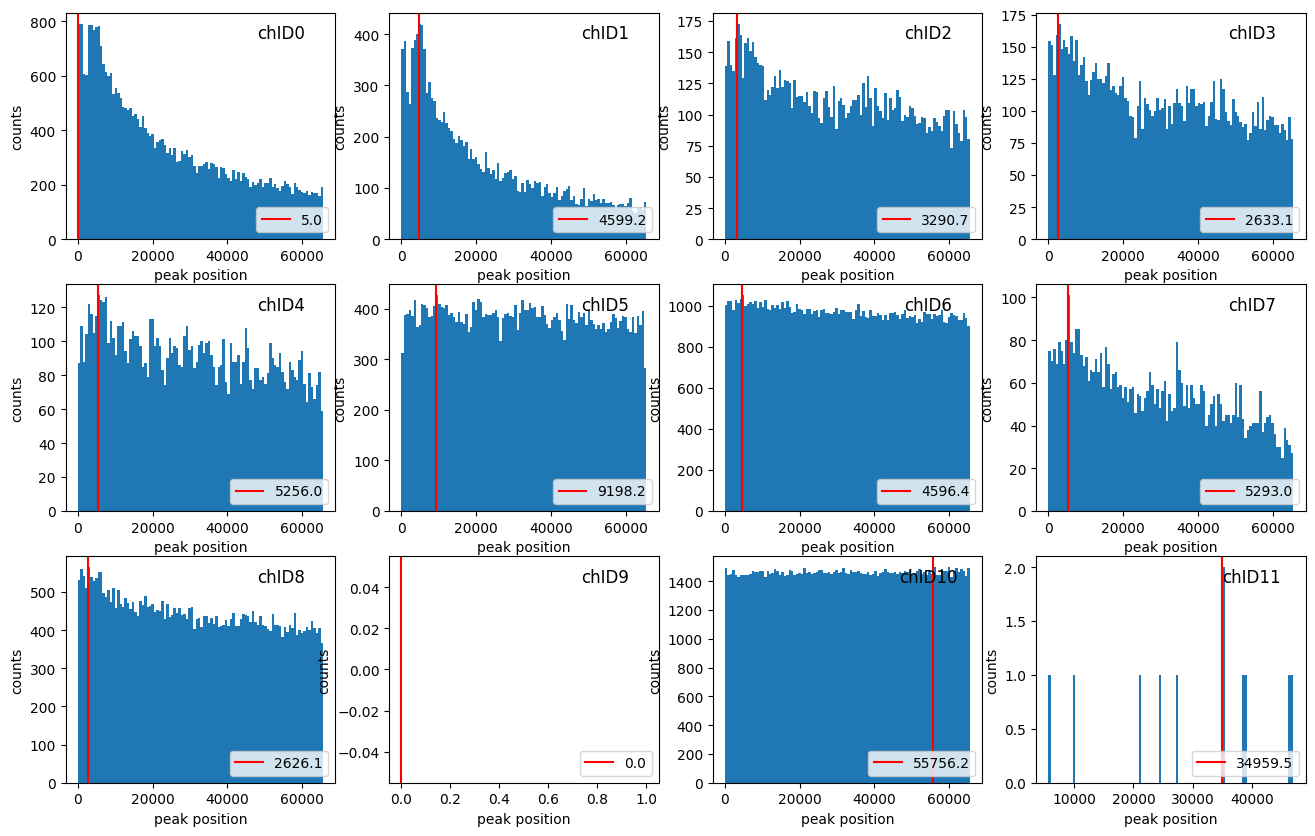

In [14]:
fig, axs = plt.subplots(3, 4, figsize=(16, 10))

for chID in range(0, Nchannels):
# for chID in range(0, 2):
    ax = axs.flatten()[chID]
    peak_indices = ak.to_numpy(ak.flatten(pulses[chID]['peak_indices_2d']))
    h = ax.hist(peak_indices, bins=100);
    ax.set_xlabel('peak position')
    ax.set_ylabel('counts')
    ax.set_title(f'chID{chID}', x=0.8,  y = 0.85)
    l = h[1][h[0].argmax()]
    ax.axvline(x = l, color='red', label=f'{l:.1f}')
    ax.legend(loc='lower right');

### peak positions after removing saturated waveforms

In [15]:
for chID in range(0, Nchannels):
    print(chID, ak.max(pulses[chID]['peak_heights']))
    
ADCmax = 16383

0 16383.0
1 16383.0
2 16383.0
3 16383.0
4 16383.0
5 16383.0
6 16383.0
7 16383.0
8 16383.0
9 None
10 16383.0
11 871.0


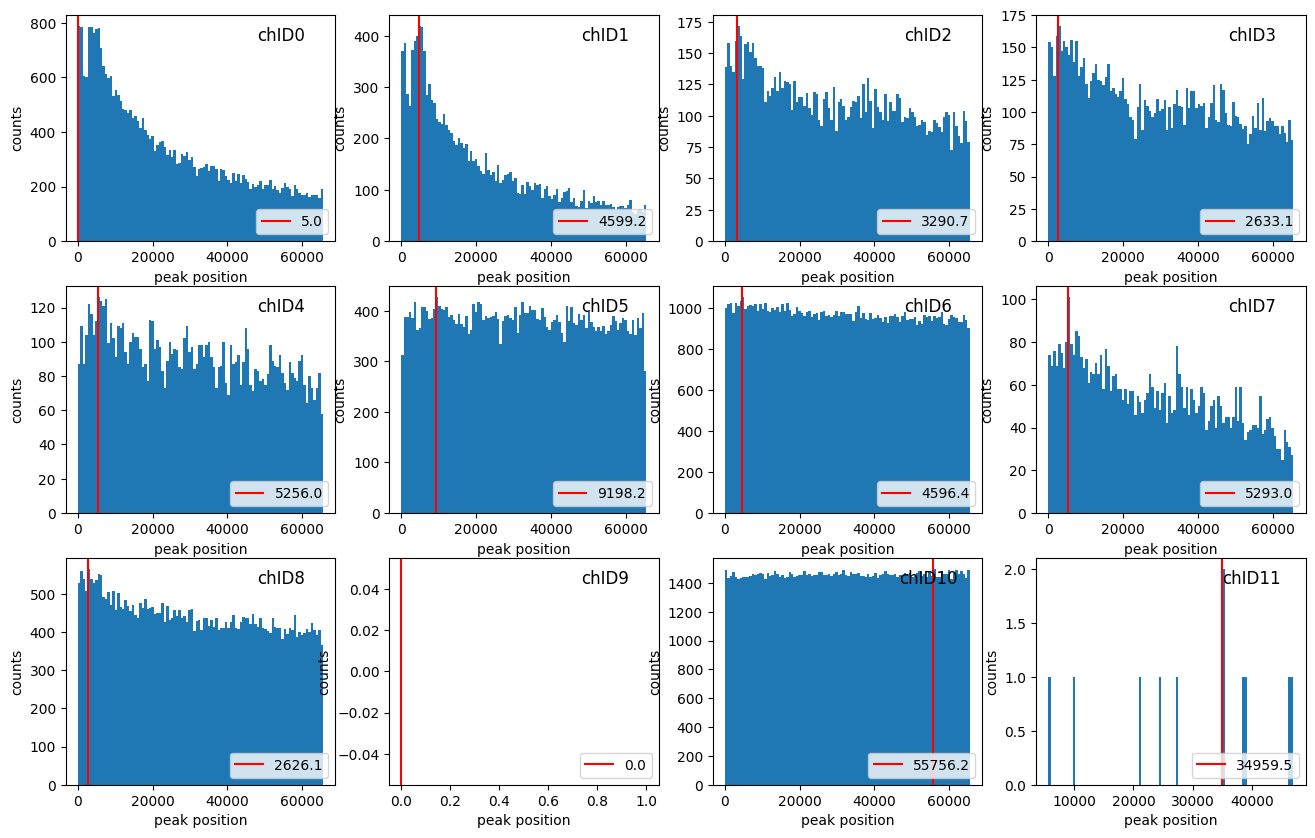

In [16]:
fig, axs = plt.subplots(3, 4, figsize=(16, 10))
ADCsat = ADCmax
for chID in range(0, Nchannels):
    ax = axs.flatten()[chID]
    positions = ak.Array(pulses[chID]['peak_indices_2d'])
    heights   = ak.Array(pulses[chID]['peak_heights'])
    mask = heights < ADCsat
    selected_positions = positions[mask]
    peak_indices = ak.to_numpy(ak.flatten(selected_positions))
    h = ax.hist(peak_indices, bins=100);
    ax.set_xlabel('peak position')
    ax.set_ylabel('counts')
    ax.set_title(f'chID{chID}', x=0.8,  y = 0.85)
    l = h[1][h[0].argmax()]
    ax.axvline(x = l, color='red', label=f'{l:.1f}')
    ax.legend(loc='lower right');

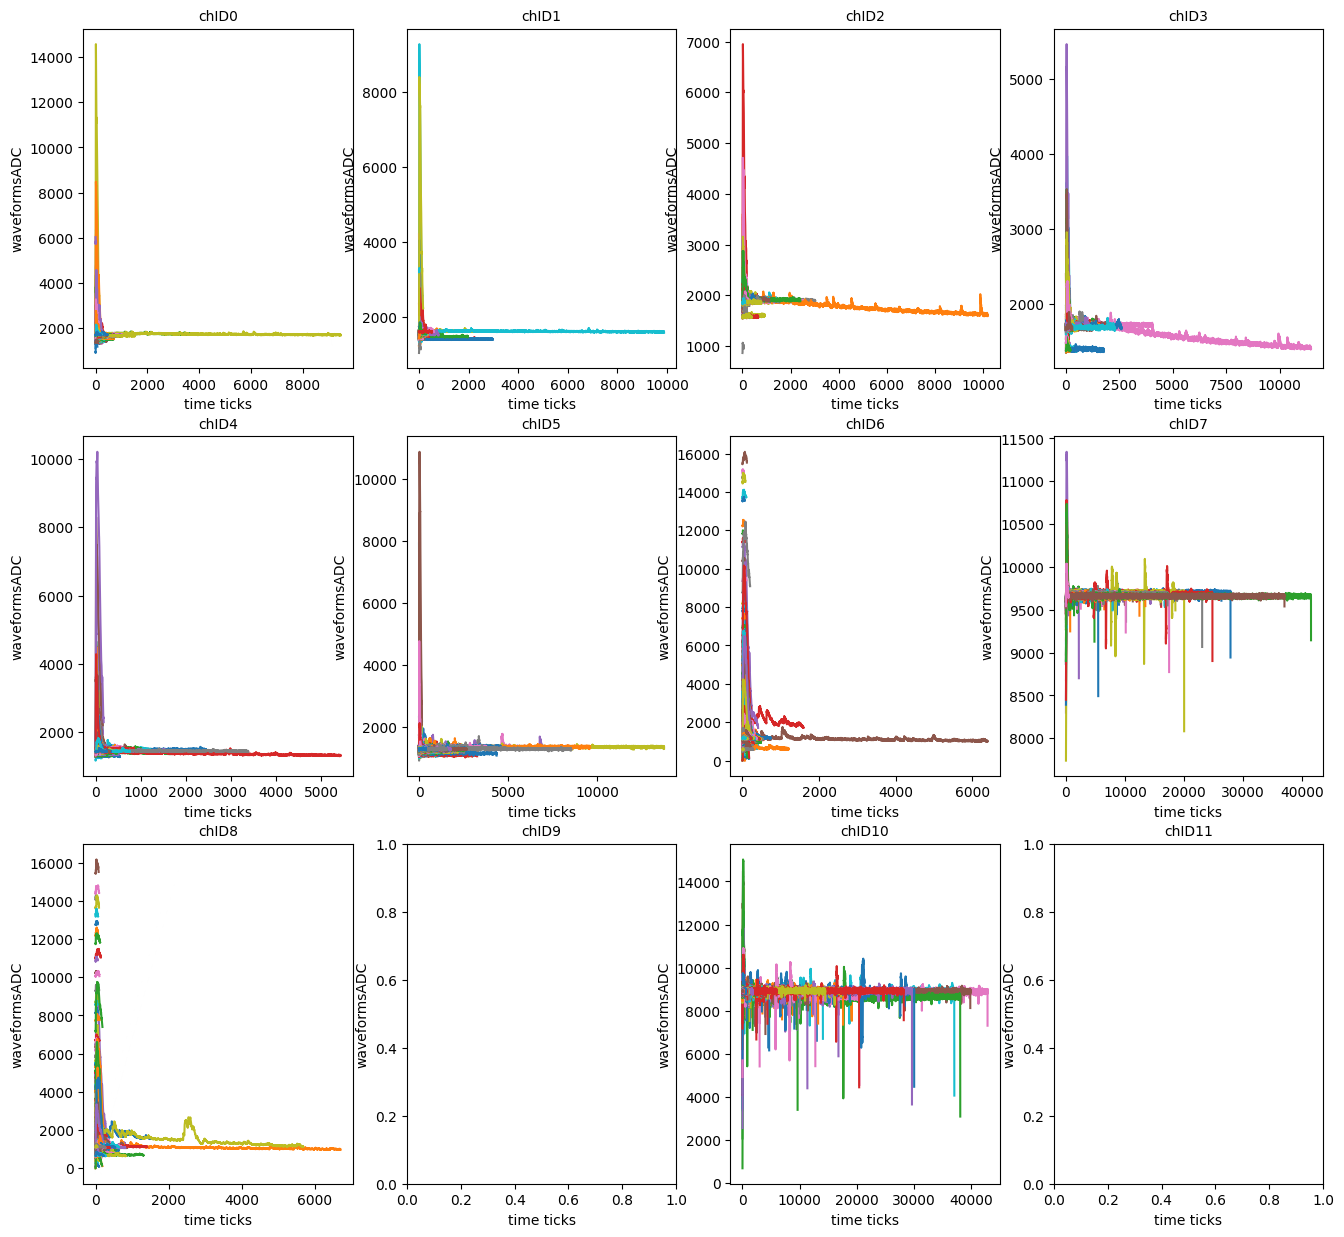

In [17]:
fig, axs = plt.subplots(3, 4, figsize=(16, 15))

evtID = 0
x = np.arange(0,TrigWindow, 1)
y = 'waveformsADC'

a = 0
for chID in range(0, Nchannels):
    ax = axs.flatten()[a]
    for evtID in range(0, 10):
        for pulseID in range(0, len(pulses[chID]['waveforms'][evtID])): 
            if ak.max(pulses[chID]['waveforms'][evtID][pulseID]) < ADCsat:
                ax.plot(pulses[chID]['waveforms'][evtID][pulseID]);
    ax.set_xlabel('time ticks')
    ax.set_ylabel(y)
    ax.set_title(f'chID{chID}', fontsize=10)
    a+=1



In [ ]:

# ## find integration window (Vitaliy's method)
# # 1. Get derivative of avg. waveform
# # 2. Selecting the interval between the spike (rising edge) and “getting back to 0” for the waveform derivative

# # pulses_sel = pulses_bs

# avg_wf      = pulses_sel.mean(axis=0)
# avg_wf_diff = np.diff(avg_wf)

# fig, axs = plt.subplots(1, 2, figsize=(8, 3))
# ax = axs[0]
# ax.plot(np.arange(0, len(avg_wf), 1), avg_wf);
# ax.set_xlabel(r"$\mathrm{\bf time ticks}$");
# ax.set_ylabel(r"$\mathrm{\bf ADC Counts}$");
# ax.set_title(r"waveform");
# # ax.set_xlim(0, 400)

# rising_edge_idx = np.argmax(avg_wf_diff)
# bound_min = np.argmax(avg_wf_diff) # rising edge
# min_idx = np.argmin(avg_wf_diff)
# epsilon = 0.4
# for i in range(min_idx, len(avg_wf_diff)):
#     if abs(avg_wf_diff[i]) < epsilon:
#         print(i)
#         bound_max = i + 1
#         break

# ax.axvline(x=bound_min, color='black')
# ax.axvline(x=bound_max, color='black')
# ax = axs[1]
# ax.plot(np.arange(0, len(avg_wf_diff), 1), avg_wf_diff);
# ax.axhline(y=0, color='black')
# ax.set_xlabel(r"$\mathrm{\bf time ticks}$");
# ax.set_ylabel(r"$\mathrm{\bf ADC Counts}$");
# ax.set_title(r"waveform derivative");
# ax.axvline(x=bound_min, color='black')
# ax.axvline(x=bound_max, color='black');